### Notebook for the CCCI-derived metabolism from scRNA-Seq using `mebocost` - Mixed cell states Healthy-CTRL

- **Developed by**: Carlos Talavera-López Ph.D
- **Institute of Computational Biology - Computational Health Centre - Hemlholtz Munich**
- v230510

### Import required modules

In [1]:
import os,sys
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from mebocost import mebocost

Warning (xlmhg): Failed to import "mhg_cython" C extension.
Warning (xlmhg): Failed to import the "mhg_cython" C extension.Falling back to the pure Python implementation, which is very slow.


In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.8.0
scanpy      1.8.2
sinfo       0.3.4
-----
Cython              0.29.33
PIL                 9.4.0
adjustText          NA
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
comm                0.1.3
cpuinfo             NA
cycler              0.10.0
cython              0.29.33
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
defusedxml         

### Read in dataset

In [4]:
adata = sc.read_h5ad('../../../data/Healthy-CTRL_Mixed_scVI-annotated_ctl230504.h5ad') 
adata

AnnData object with n_obs × n_vars = 717 × 7000
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_by_counts-

In [22]:
adata.obs['leiden_states'].cat.categories

Index(['Mixed_11', 'Mixed_12', 'Mixed_13', 'Mixed_16', 'Mixed_17'], dtype='object')

- Is data raw?

In [5]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis = 0))

In [6]:
X_is_raw(adata)

True

### Infer Highly Variable Genes to speed up and improve inference

In [7]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True
)

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 717 × 7000
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_by_counts-

### Infer metabolic communications

- The `mebocost.conf` file needs to be provided. It is in the original repo and after installation it will have the correct paths and should work out of the box. You could provide the full path to the file, or create a symlink. 

In [8]:
mebo_obj = mebocost.create_obj(
                        adata = adata,
                        group_col = ['leiden_states'],
                        met_est = 'mebocost',
                        config_path = './mebocost.conf',
                        exp_mat = None,
                        cell_ann = None,
                        species = 'human',
                        met_pred = None,
                        met_enzyme = None,
                        met_sensor = None,
                        met_ann = None,
                        scFEA_ann = None,
                        compass_met_ann = None,
                        compass_rxn_ann = None,
                        gene_network = None,
                        gmt_path = None,
                        cutoff_exp = 'auto', ## automated cutoff to exclude lowly ranked 25% sensors across all cells
                        cutoff_met = 'auto', ## automated cutoff to exclude lowly ranked 25% metabolites across all cells
                        cutoff_prop = 0.25, ## at lease 25% of cells should be expressed the sensor or present the metabolite in the cell group (specified by group_col)
                        sensor_type = ['Receptor', 'Transporter', 'Nuclear Receptor'],
                        thread = 4
                        )

[May 10, 2023 11:32:54]: We get expression data with 7000 genes and 717 cells.
[May 10, 2023 11:32:54]: Data Preparation Done in 0.0200 seconds


### Estimate metabolite presence

- If you just want the table of metabolic activity, you can stop here and export it as a CSV file. 

In [10]:
mebo_obj._load_config_()
mebo_obj.estimator()

[May 10, 2023 11:33:44]: Load config and read data based on given species [human].
[May 10, 2023 11:33:46]: Estimtate metabolite level using mebocost


In [11]:
met_mat = pd.DataFrame(mebo_obj.met_mat.toarray(),
                      index = mebo_obj.met_mat_indexer,
                      columns = mebo_obj.met_mat_columns)
met_mat.head()

307691-ST07_CSE_CTRL-V1  390878-ST07_CSE_CTRL-V1  \
HMDB0003948                      1.0                 0.500000   
HMDB0003712                      1.0                 0.333333   
HMDB0003945                      6.0                 0.800000   
HMDB0003949                      1.0                 0.500000   
HMDB0001188                      7.0                 1.000000   

             108750-ST07_CSE_CTRL-V1  171370-ST07_CSE_CTRL-V1  \
HMDB0003948                      0.5                 1.500000   
HMDB0003712                      1.5                 1.333333   
HMDB0003945                      2.8                 4.800000   
HMDB0003949                      0.5                 1.500000   
HMDB0001188                      0.0                 6.000000   

             103076-ST07_CSE_CTRL-V1  188988-ST07_CSE_CTRL-V1  \
HMDB0003948                 0.500000                 0.250000   
HMDB0003712                 0.833333                 0.333333   
HMDB0003945                 1.400000                 3.200000   
HMDB0003949                 0.500000                 0.250000   
HMDB0001188                 5.000000                 2.000000   

             191658-ST07_CSE_CTRL-V1  138641-ST07_CSE_CTRL-V1  \
HMDB0003948                      1.0                     0.25   
HMDB0003712                      1.0                     1.00   
HMDB0003945                      2.6                     3.20   
HMDB0003949                      1.0                     0.25   
HMDB0001188                     10.0                     5.00   

             25797-ST07_CSE_CTRL-V1  845131-ST07_CSE_CTRL-V1  ...  \
HMDB0003948                0.250000                 0.000000  ...   
HMDB0003712                0.166667                 0.166667  ...   
HMDB0003945                2.200000                 1.400000  ...   
HMDB0003949                0.250000                 0.000000  ...   
HMDB0001188                0.000000                 0.000000  ...   

             9163059-GER02_CTRL-V6  1795999-GER02_CTRL-V6  9267-GER02_CTRL-V6  \
HMDB0003948                    0.0                    0.0            0.500000   
HMDB0003712                    0.0                    0.0            0.333333   
HMDB0003945                    1.0                    2.2            1.600000   
HMDB0003949                    0.0                    0.0            0.500000   
HMDB0001188                    5.0                    0.0            1.000000   

             2071726-GER02_CTRL-V6  1067212-GER02_CTRL-V6  \
HMDB0003948                    0.0                    0.0   
HMDB0003712                    0.0                    0.0   
HMDB0003945                    0.2                    0.4   
HMDB0003949                    0.0                    0.0   
HMDB0001188                    3.0                    0.0   

             11823009-GER02_CTRL-V6  169785-GER02_CTRL-V6  \
HMDB0003948                0.000000              0.250000   
HMDB0003712                0.166667              0.166667   
HMDB0003945                0.400000              1.200000   
HMDB0003949                0.000000              0.250000   
HMDB0001188                0.000000              0.000000   

             8126236-GER02_CTRL-V6  620583-GER02_CTRL-V6  \
HMDB0003948               0.250000              0.000000   
HMDB0003712               0.166667              0.166667   
HMDB0003945               1.400000              1.600000   
HMDB0003949               0.250000              0.000000   
HMDB0001188               0.000000              0.000000   

             1478841-GER02_CTRL-V6  
HMDB0003948               0.250000  
HMDB0003712               0.166667  
HMDB0003945               0.200000  
HMDB0003949               0.250000  
HMDB0001188               1.000000  

[5 rows x 717 columns]

In [12]:
met_mat.shape

(394, 717)

### MEBOCOST cell-cell communication inference

In [13]:
commu_res = mebo_obj.infer_commu(
                                n_shuffle = 1000,
                                seed = 1712, 
                                Return = True, 
                                thread = 4,
                                save_permuation = False,
                                min_cell_number = 3
                            )

[May 10, 2023 11:34:04]: Load config and read data based on given species [human].
[May 10, 2023 11:34:07]: Estimtate metabolite level using mebocost
[May 10, 2023 11:34:17]: Infer communications
[May 10, 2023 11:34:17]: Sensor type used ['Transporter', 'Receptor', 'Nuclear Receptor']
[May 10, 2023 11:34:17]: Parameters: {shuffling: 1000 times, random seed: 1712, thread: 4}
[May 10, 2023 11:34:17]: met_sensor: (106, 8)
[May 10, 2023 11:34:17]: avg_exp: (826, 5) for (gene, cell) of needed
[May 10, 2023 11:34:17]: avg_met: (394, 5) for (metabolite, cell) of needed
[May 10, 2023 11:34:17]: shuffling 1000 times for generating backgroud
[May 10, 2023 11:34:17]: take exp and met avg for shuffling
[May 10, 2023 11:34:20]: thread: 4
[May 10, 2023 11:34:21]: ABCA1 ~ HMDB0006247
[May 10, 2023 11:34:21]: Normalizing Cluster Mean and Calculating Communication Score
[May 10, 2023 11:34:21]: Calculating P-value
[May 10, 2023 11:34:21]: CD36 ~ HMDB0003276
[May 10, 2023 11:34:22]: CD36 ~ HMDB0000067
[

In [14]:
print('sensor_exp cutoff: %s'%mebo_obj.cutoff_exp)
print('metabolite_presence cutoff: %s'%mebo_obj.cutoff_met)

sensor_exp cutoff: 2.0
metabolite_presence cutoff: 1.0


### Visualise MEBOCOST prediction

- Summary of the number of communication events

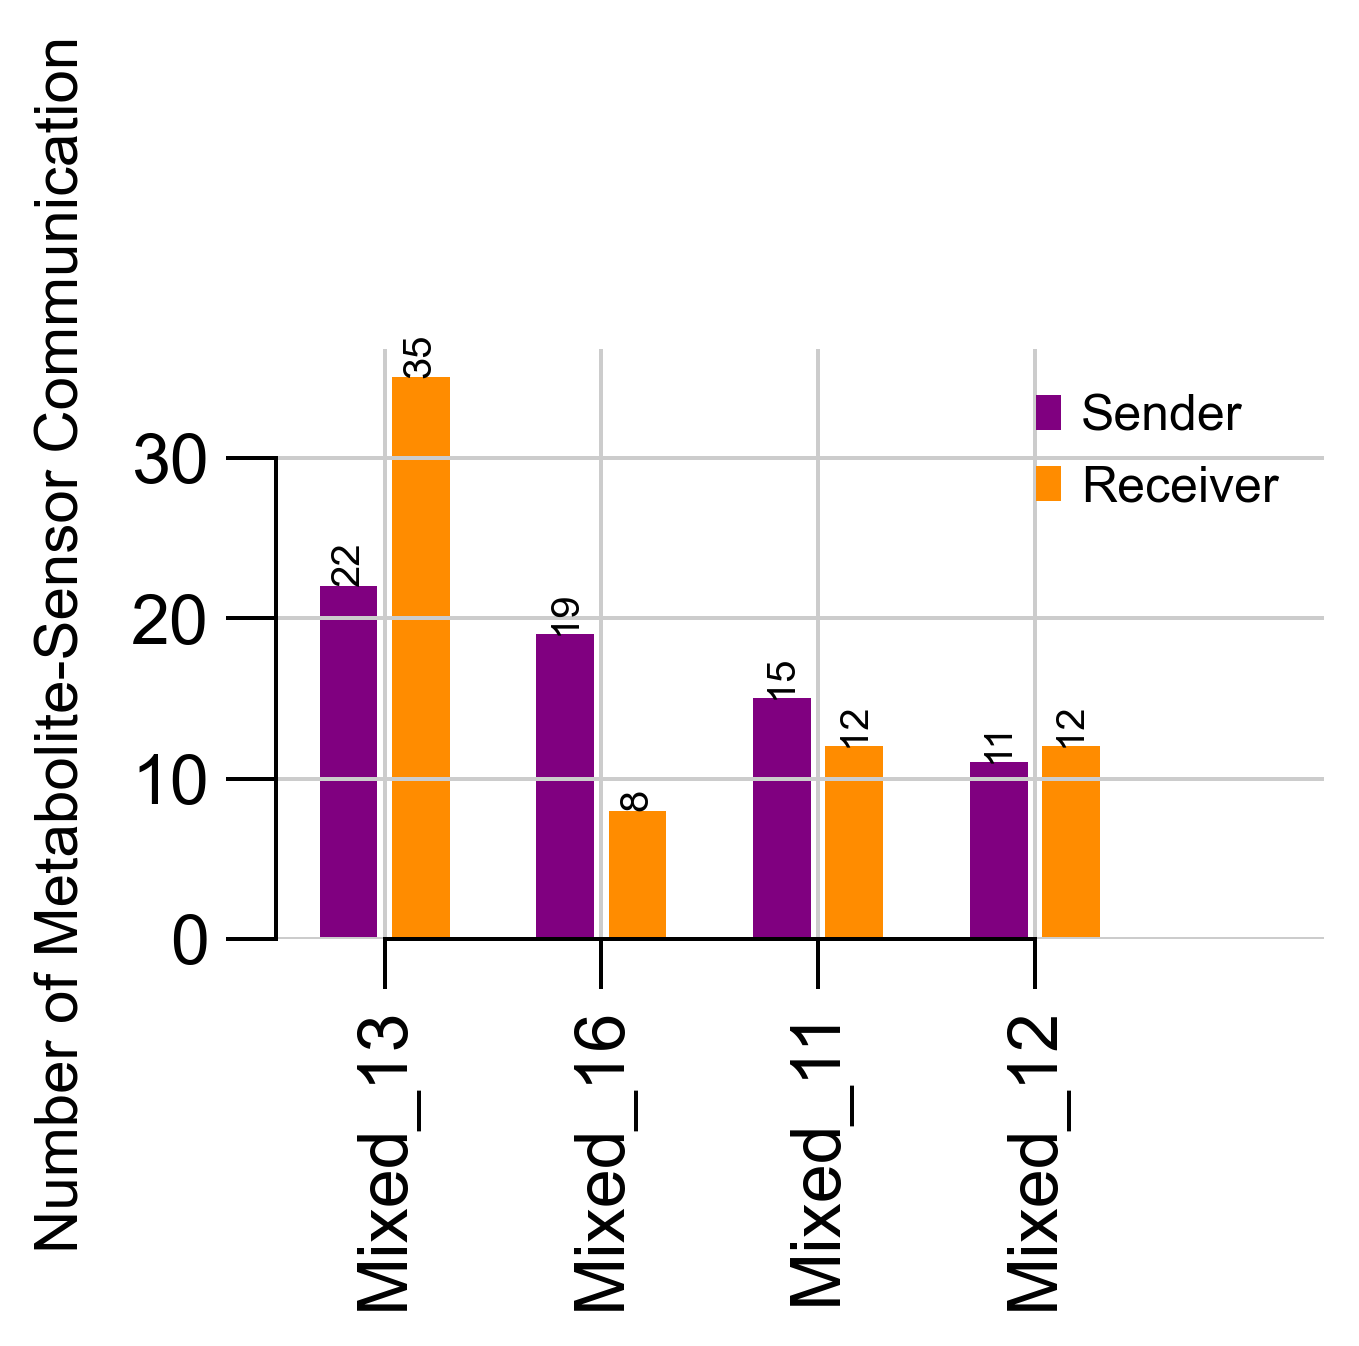

In [15]:
mebo_obj.eventnum_bar(
                    sender_focus = [],
                    metabolite_focus = [],
                    sensor_focus = [],
                    receiver_focus = [],
                    and_or = 'and',
                    pval_method = 'permutation_test_fdr',
                    pval_cutoff = 0.05,
                    comm_score_col = 'Commu_Score',
                    comm_score_cutoff = 0,
                    cutoff_prop = 0.25,
                    figsize = 'auto',
                    save = None,
                    show_plot = True,
                    show_num = True,
                    include = ['sender-receiver'],
                    group_by_cell = True,
                    colorcmap = 'tab20',
                    return_fig = False
                )

- Showing the communication between sender and receiver in a dot plot

[May 10, 2023 11:35:03]: plot dot plot to show communication in cell type level


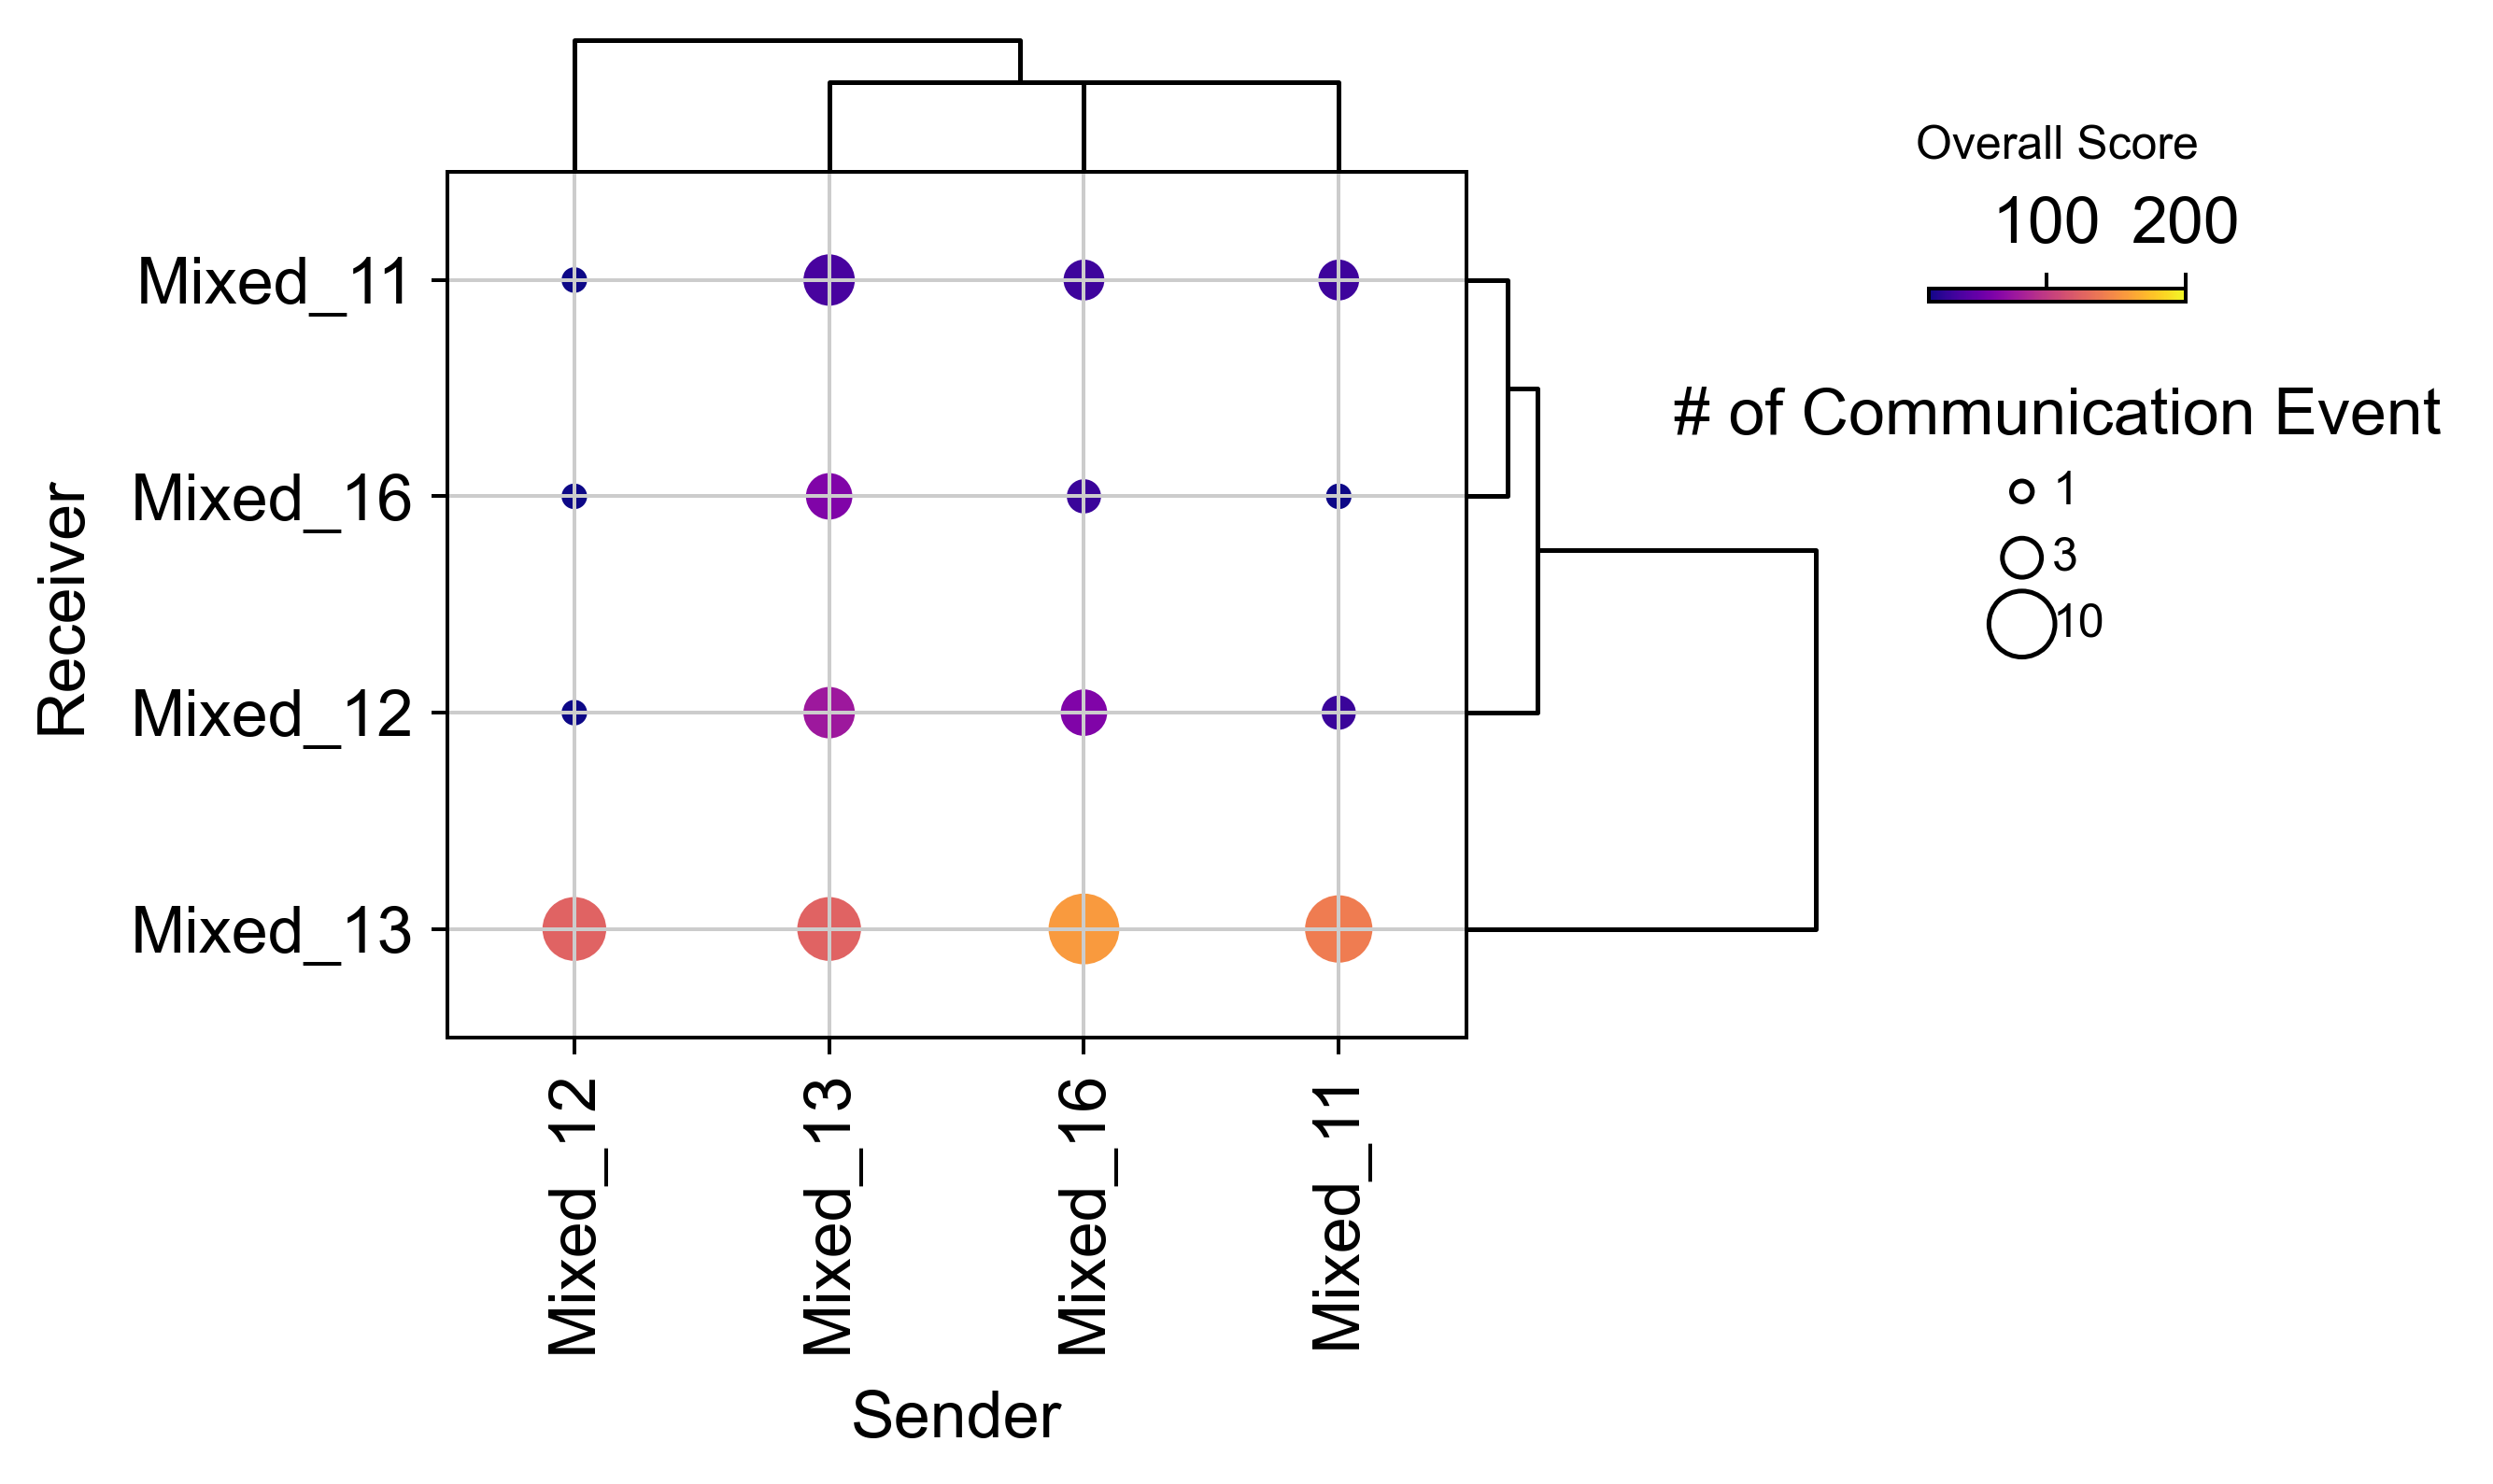

In [16]:
mebo_obj.count_dot_plot(
                        pval_method = 'permutation_test_fdr',
                        pval_cutoff = 0.05,
                        cmap = 'plasma',
                        figsize = 'auto',
                        save = None,
                        dot_size_norm = (20, 200),
                        dot_color_vmin = None,
                        dot_color_vmax = 200,
                        show_plot = True,
                        comm_score_col = 'Commu_Score',
                        comm_score_cutoff = 0,
                        return_fig = False
                    )

- Showing the detailed communications (sender-receiver vs metabolite-sensor) in a dot map

[May 10, 2023 11:35:19]: plot heatmap for significant result


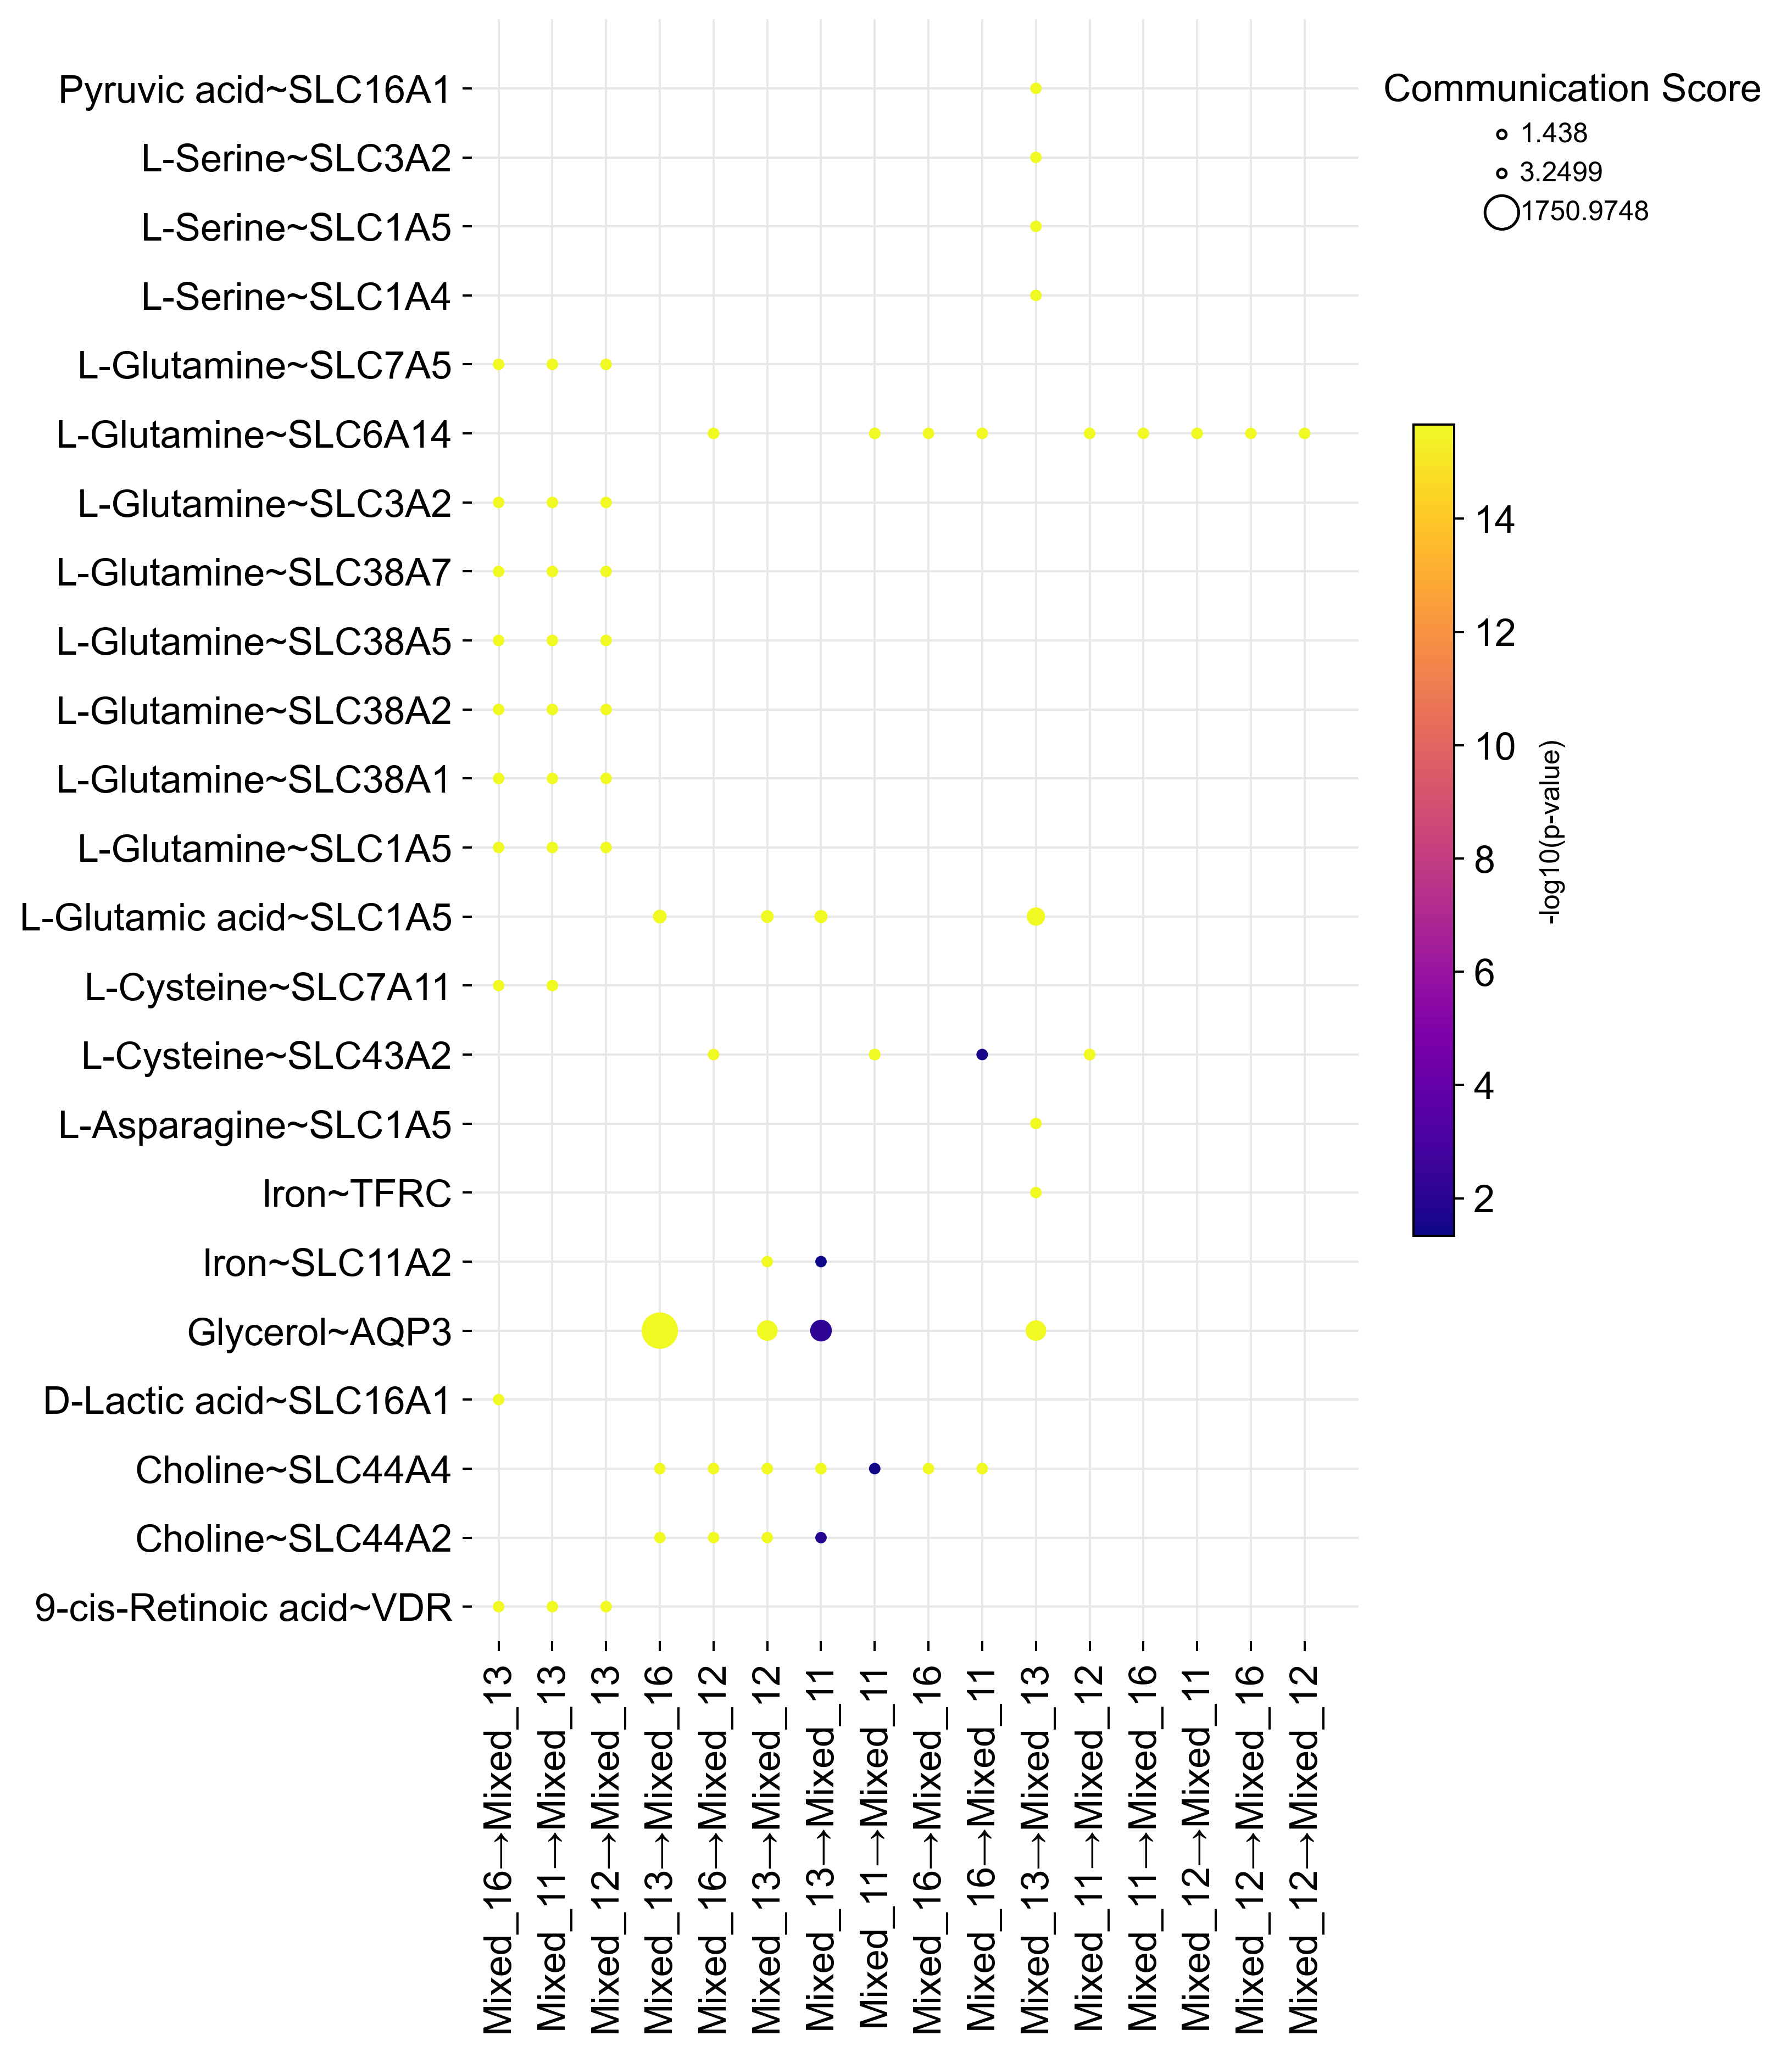

In [17]:
mebo_obj.commu_dotmap(
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                and_or = 'and',
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                figsize = 'auto',
                cmap = 'plasma',
                node_size_norm = (10, 150),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                swap_axis = False,
                return_fig = False
                )

- Visualization of the communication flow from sender metabolite to sensor in receiver

[May 10, 2023 11:35:38]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


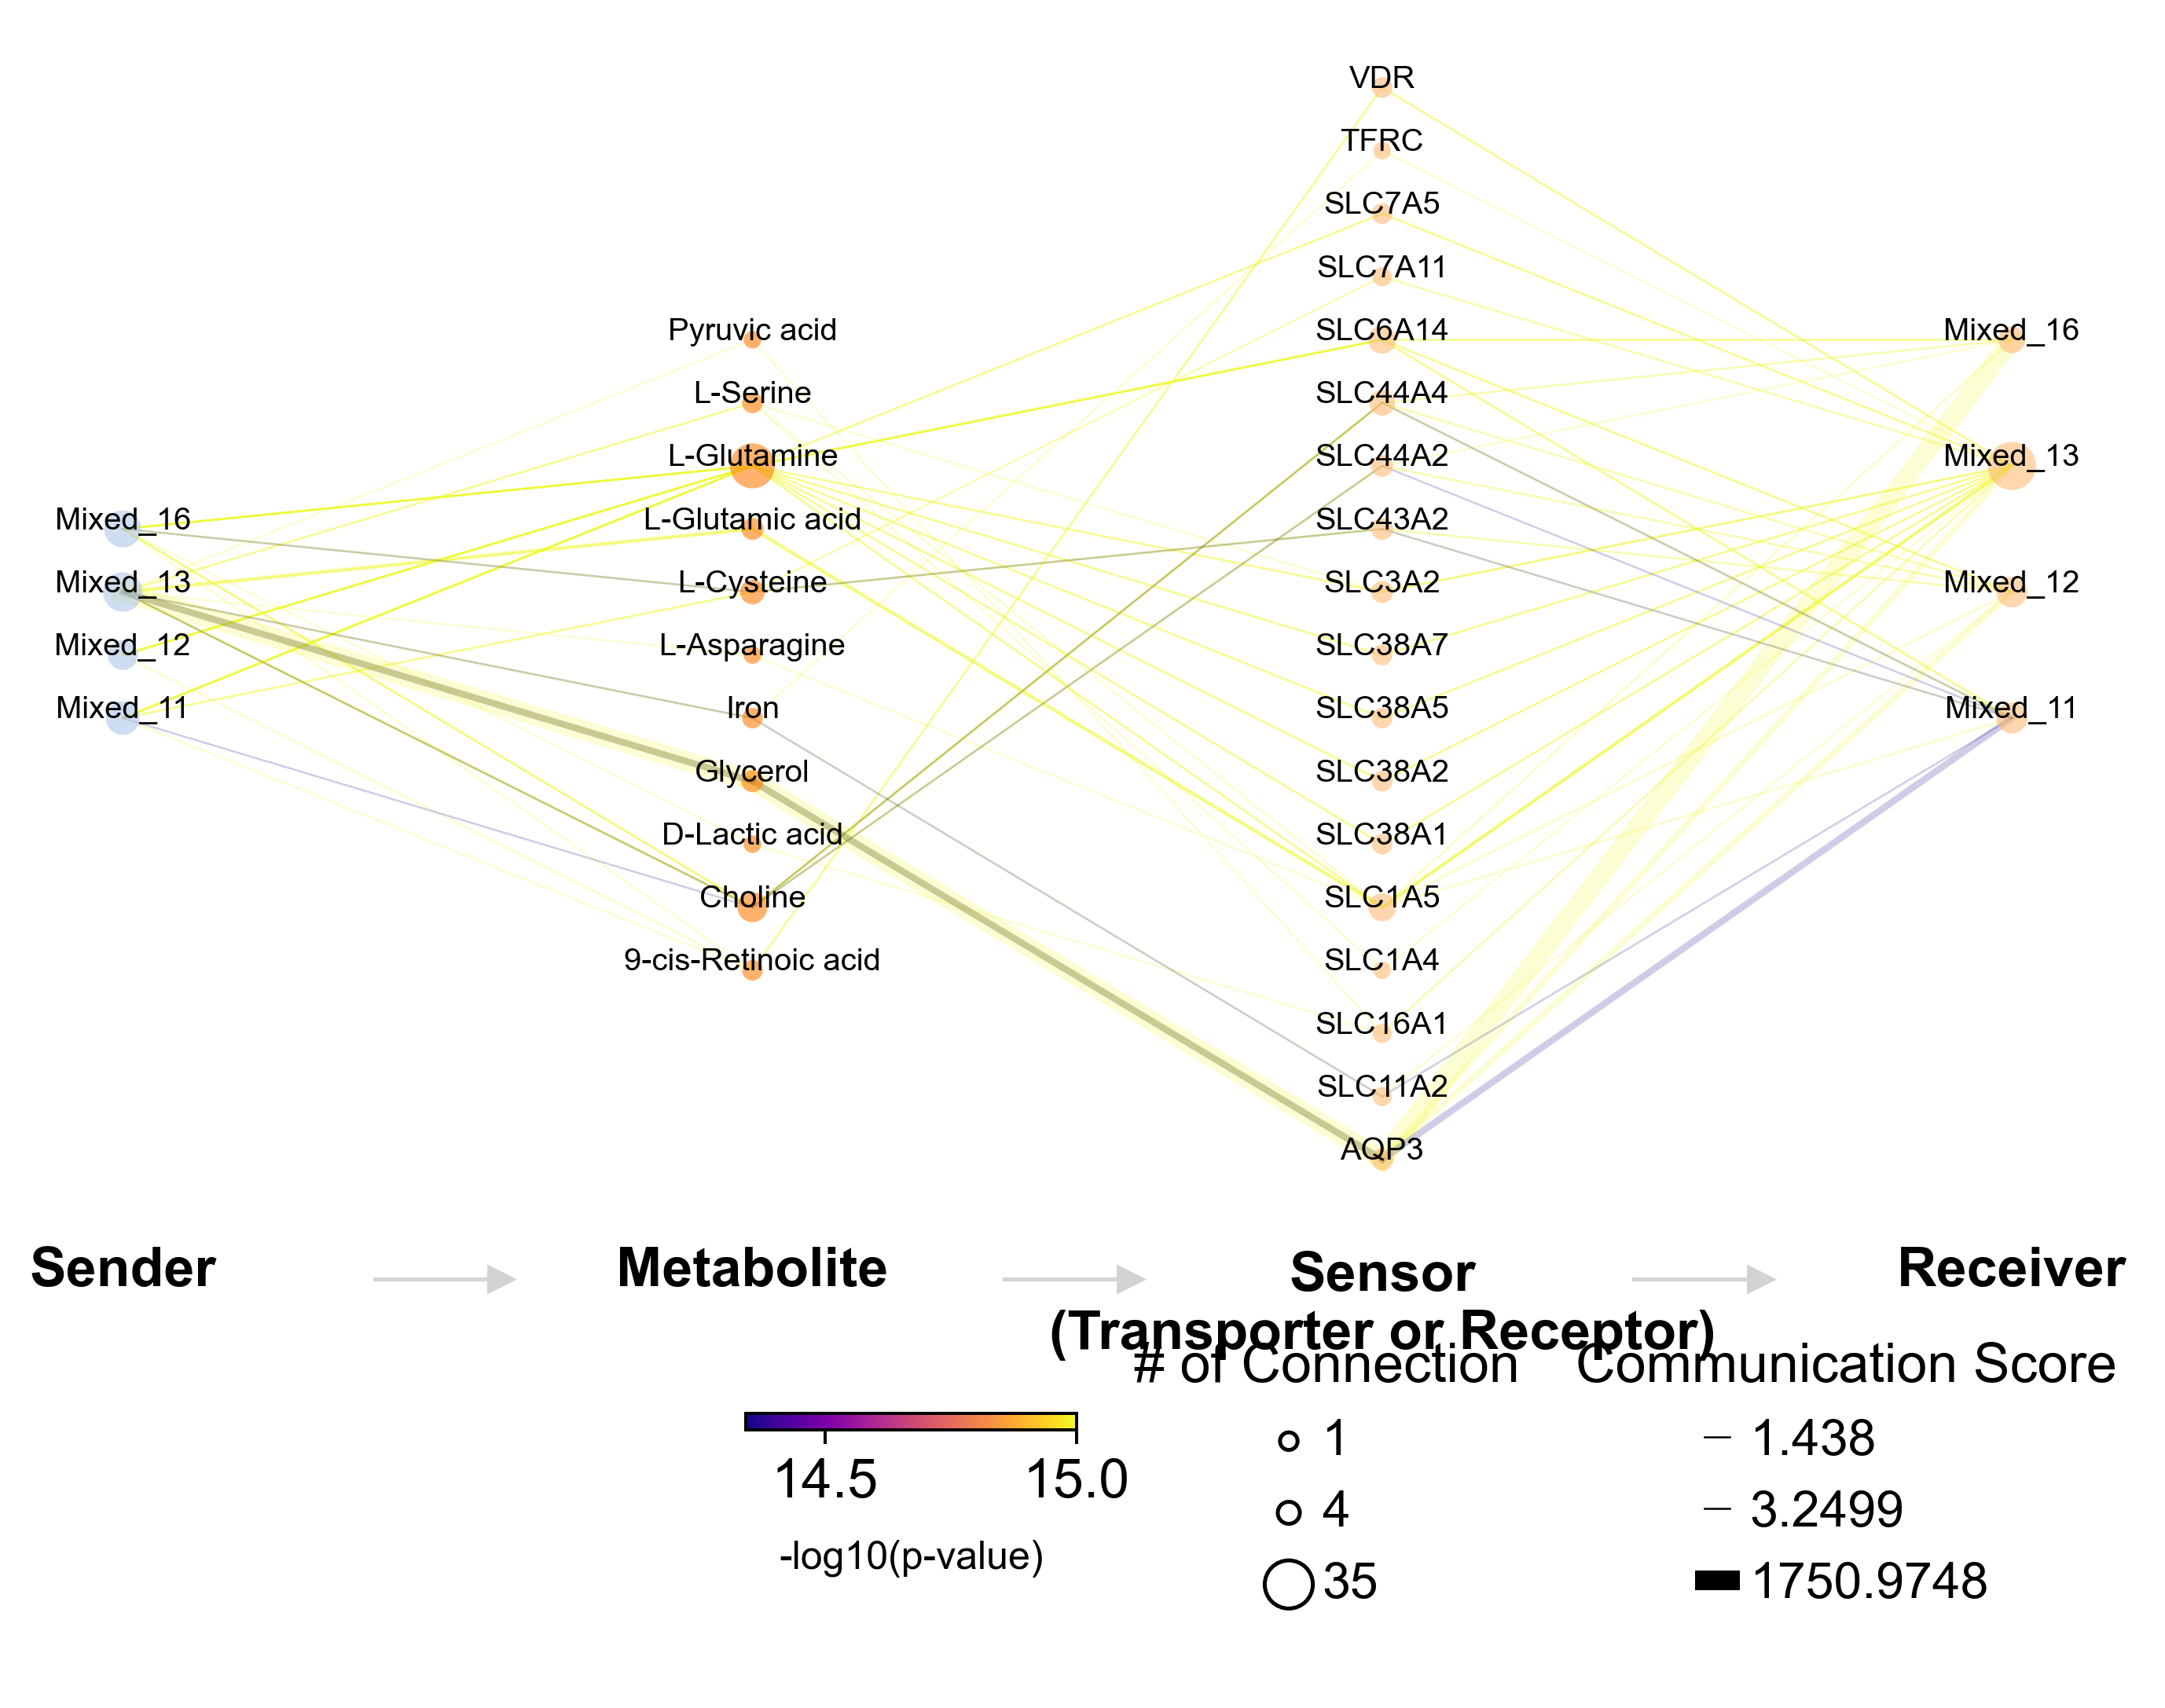

In [18]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                remove_unrelevant = False,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = 'auto',
                node_cmap = 'tab20',
                line_cmap = 'plasma',
                line_vmin = None,
                line_vmax = 15,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

[May 10, 2023 11:35:54]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


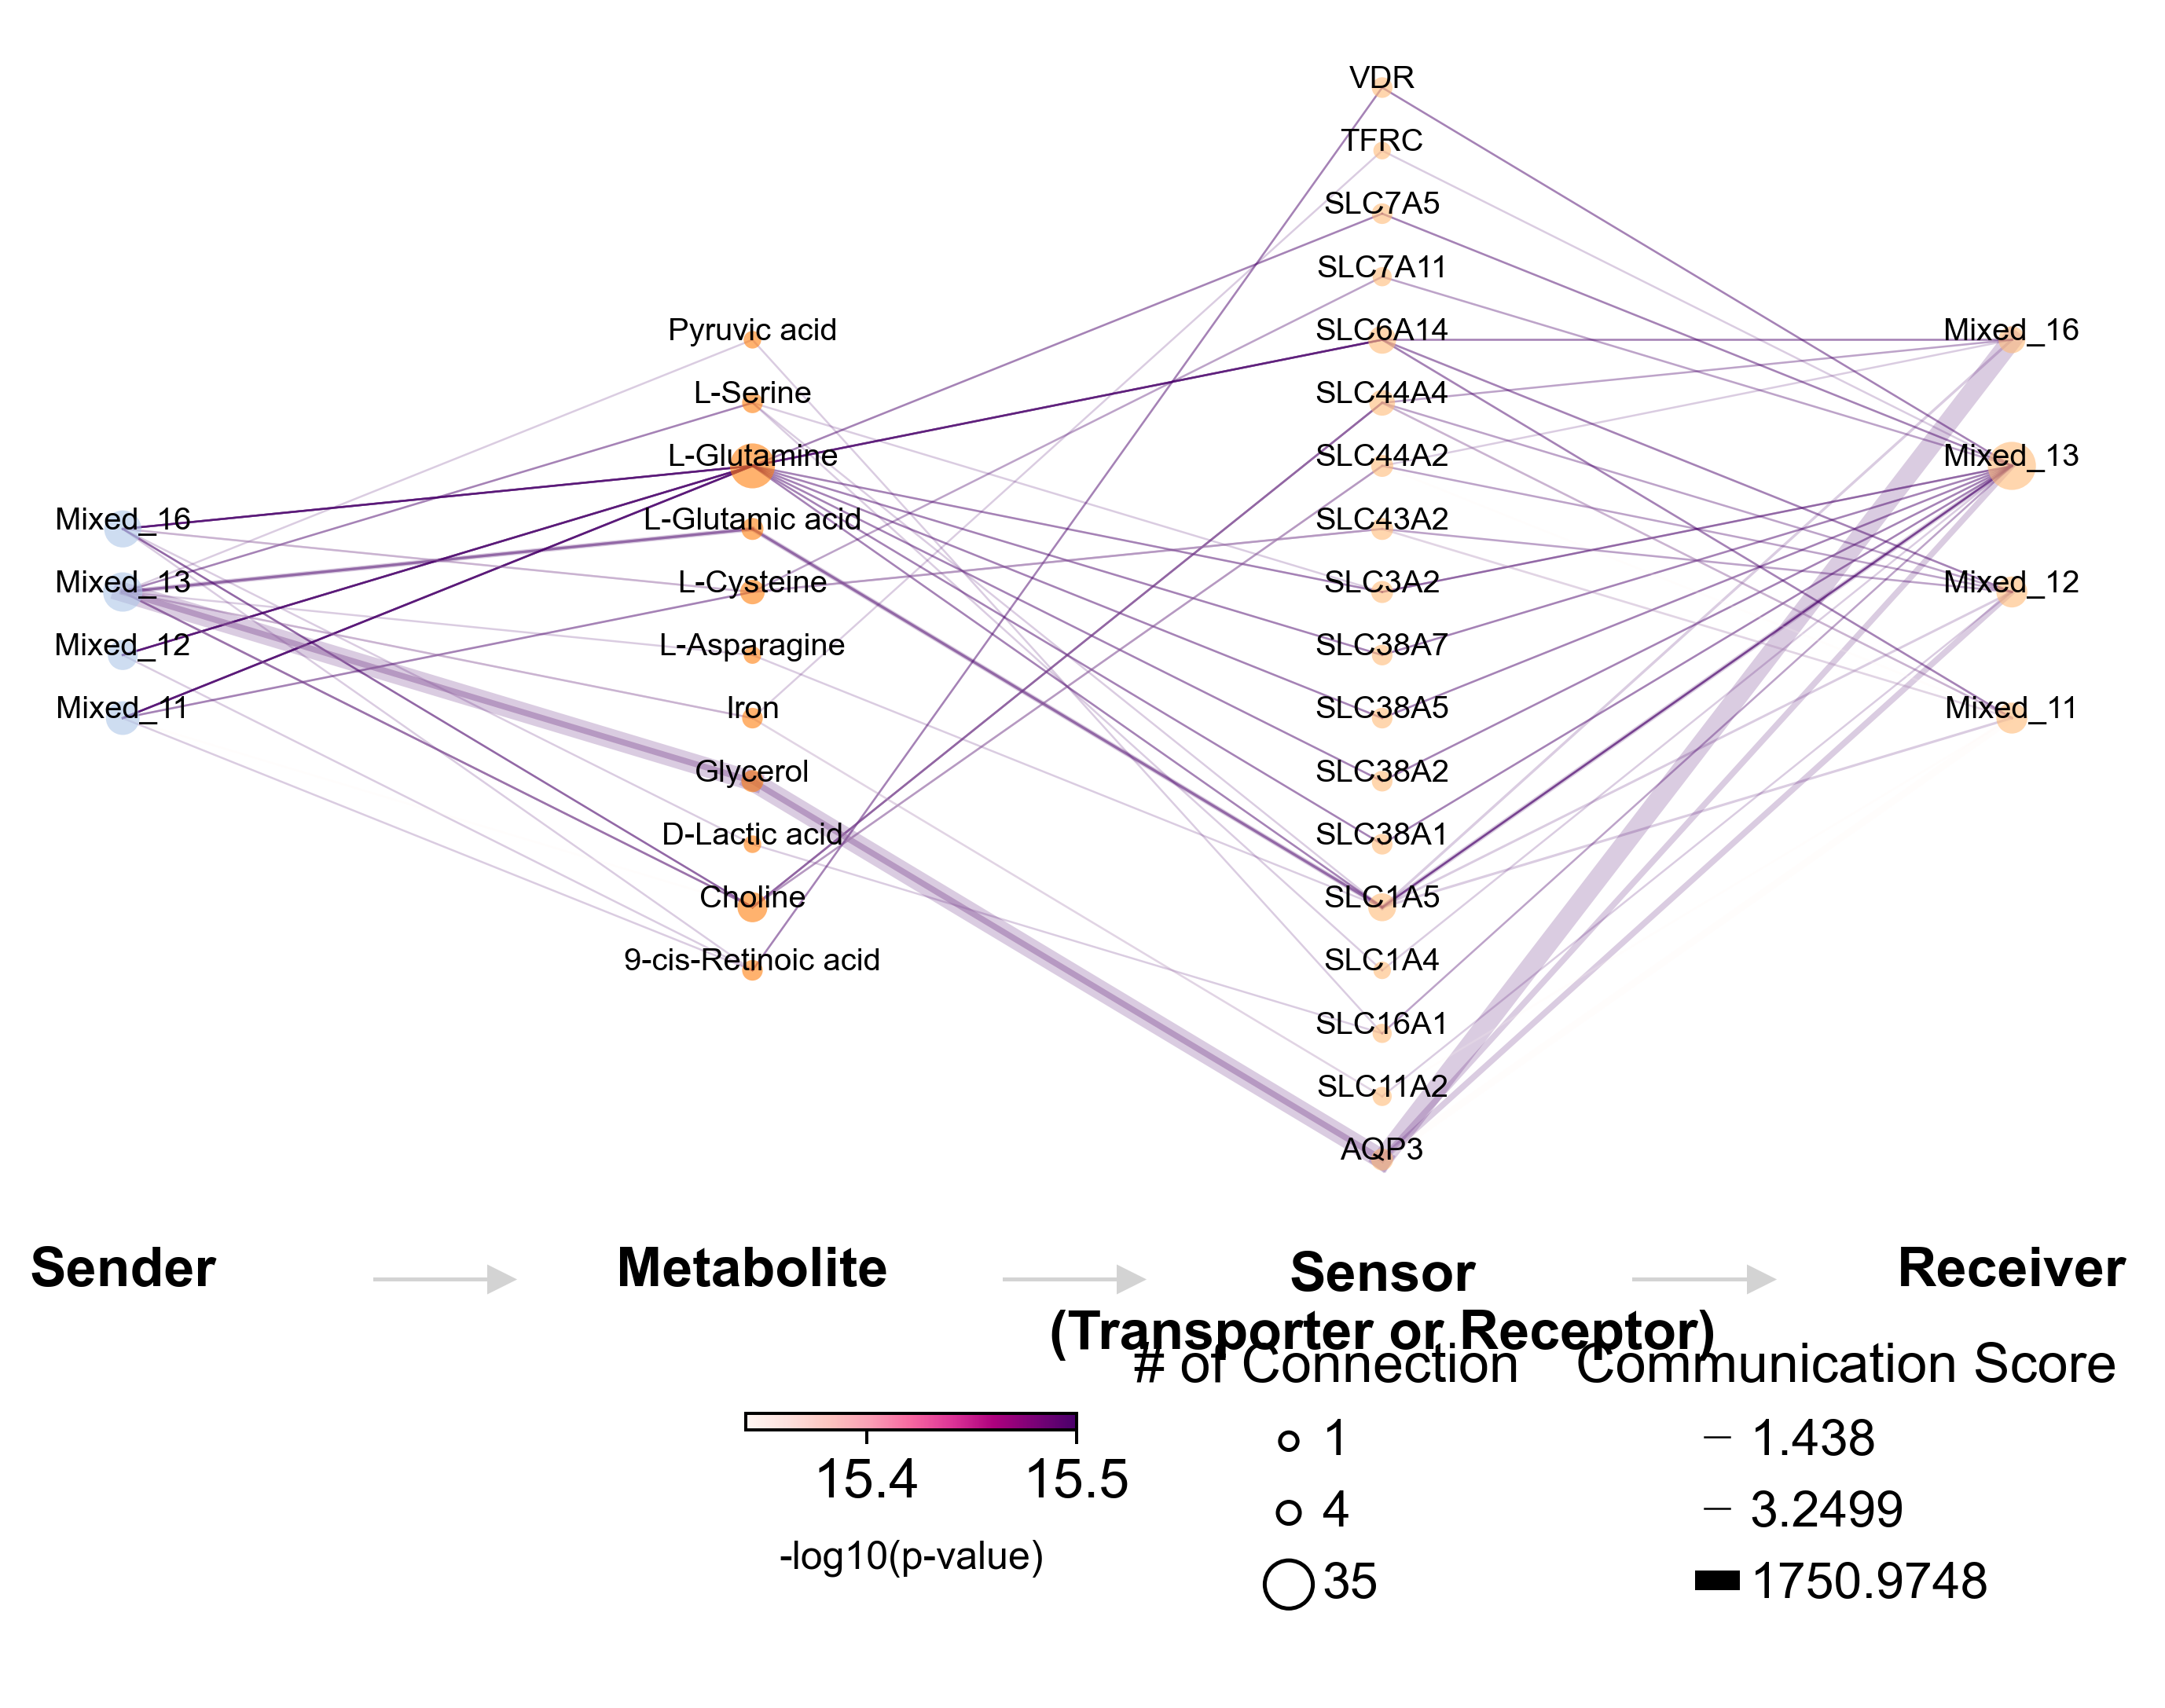

In [19]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                remove_unrelevant = False,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = 'auto',
                node_cmap = 'tab20',
                line_cmap = 'RdPu',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

- Visualization of the metabolite level or sensor expression in cell groups

[May 10, 2023 11:36:05]: Warnings: no sensors to plot
[May 10, 2023 11:36:05]: Find metabolites ['L-Asparagine', 'D-Lactic acid', 'L-Glutamic acid', 'L-Serine', 'L-Cysteine', 'Iron', '9-cis-Retinoic acid', 'Glycerol', 'Choline', 'L-Glutamine'] to plot violin


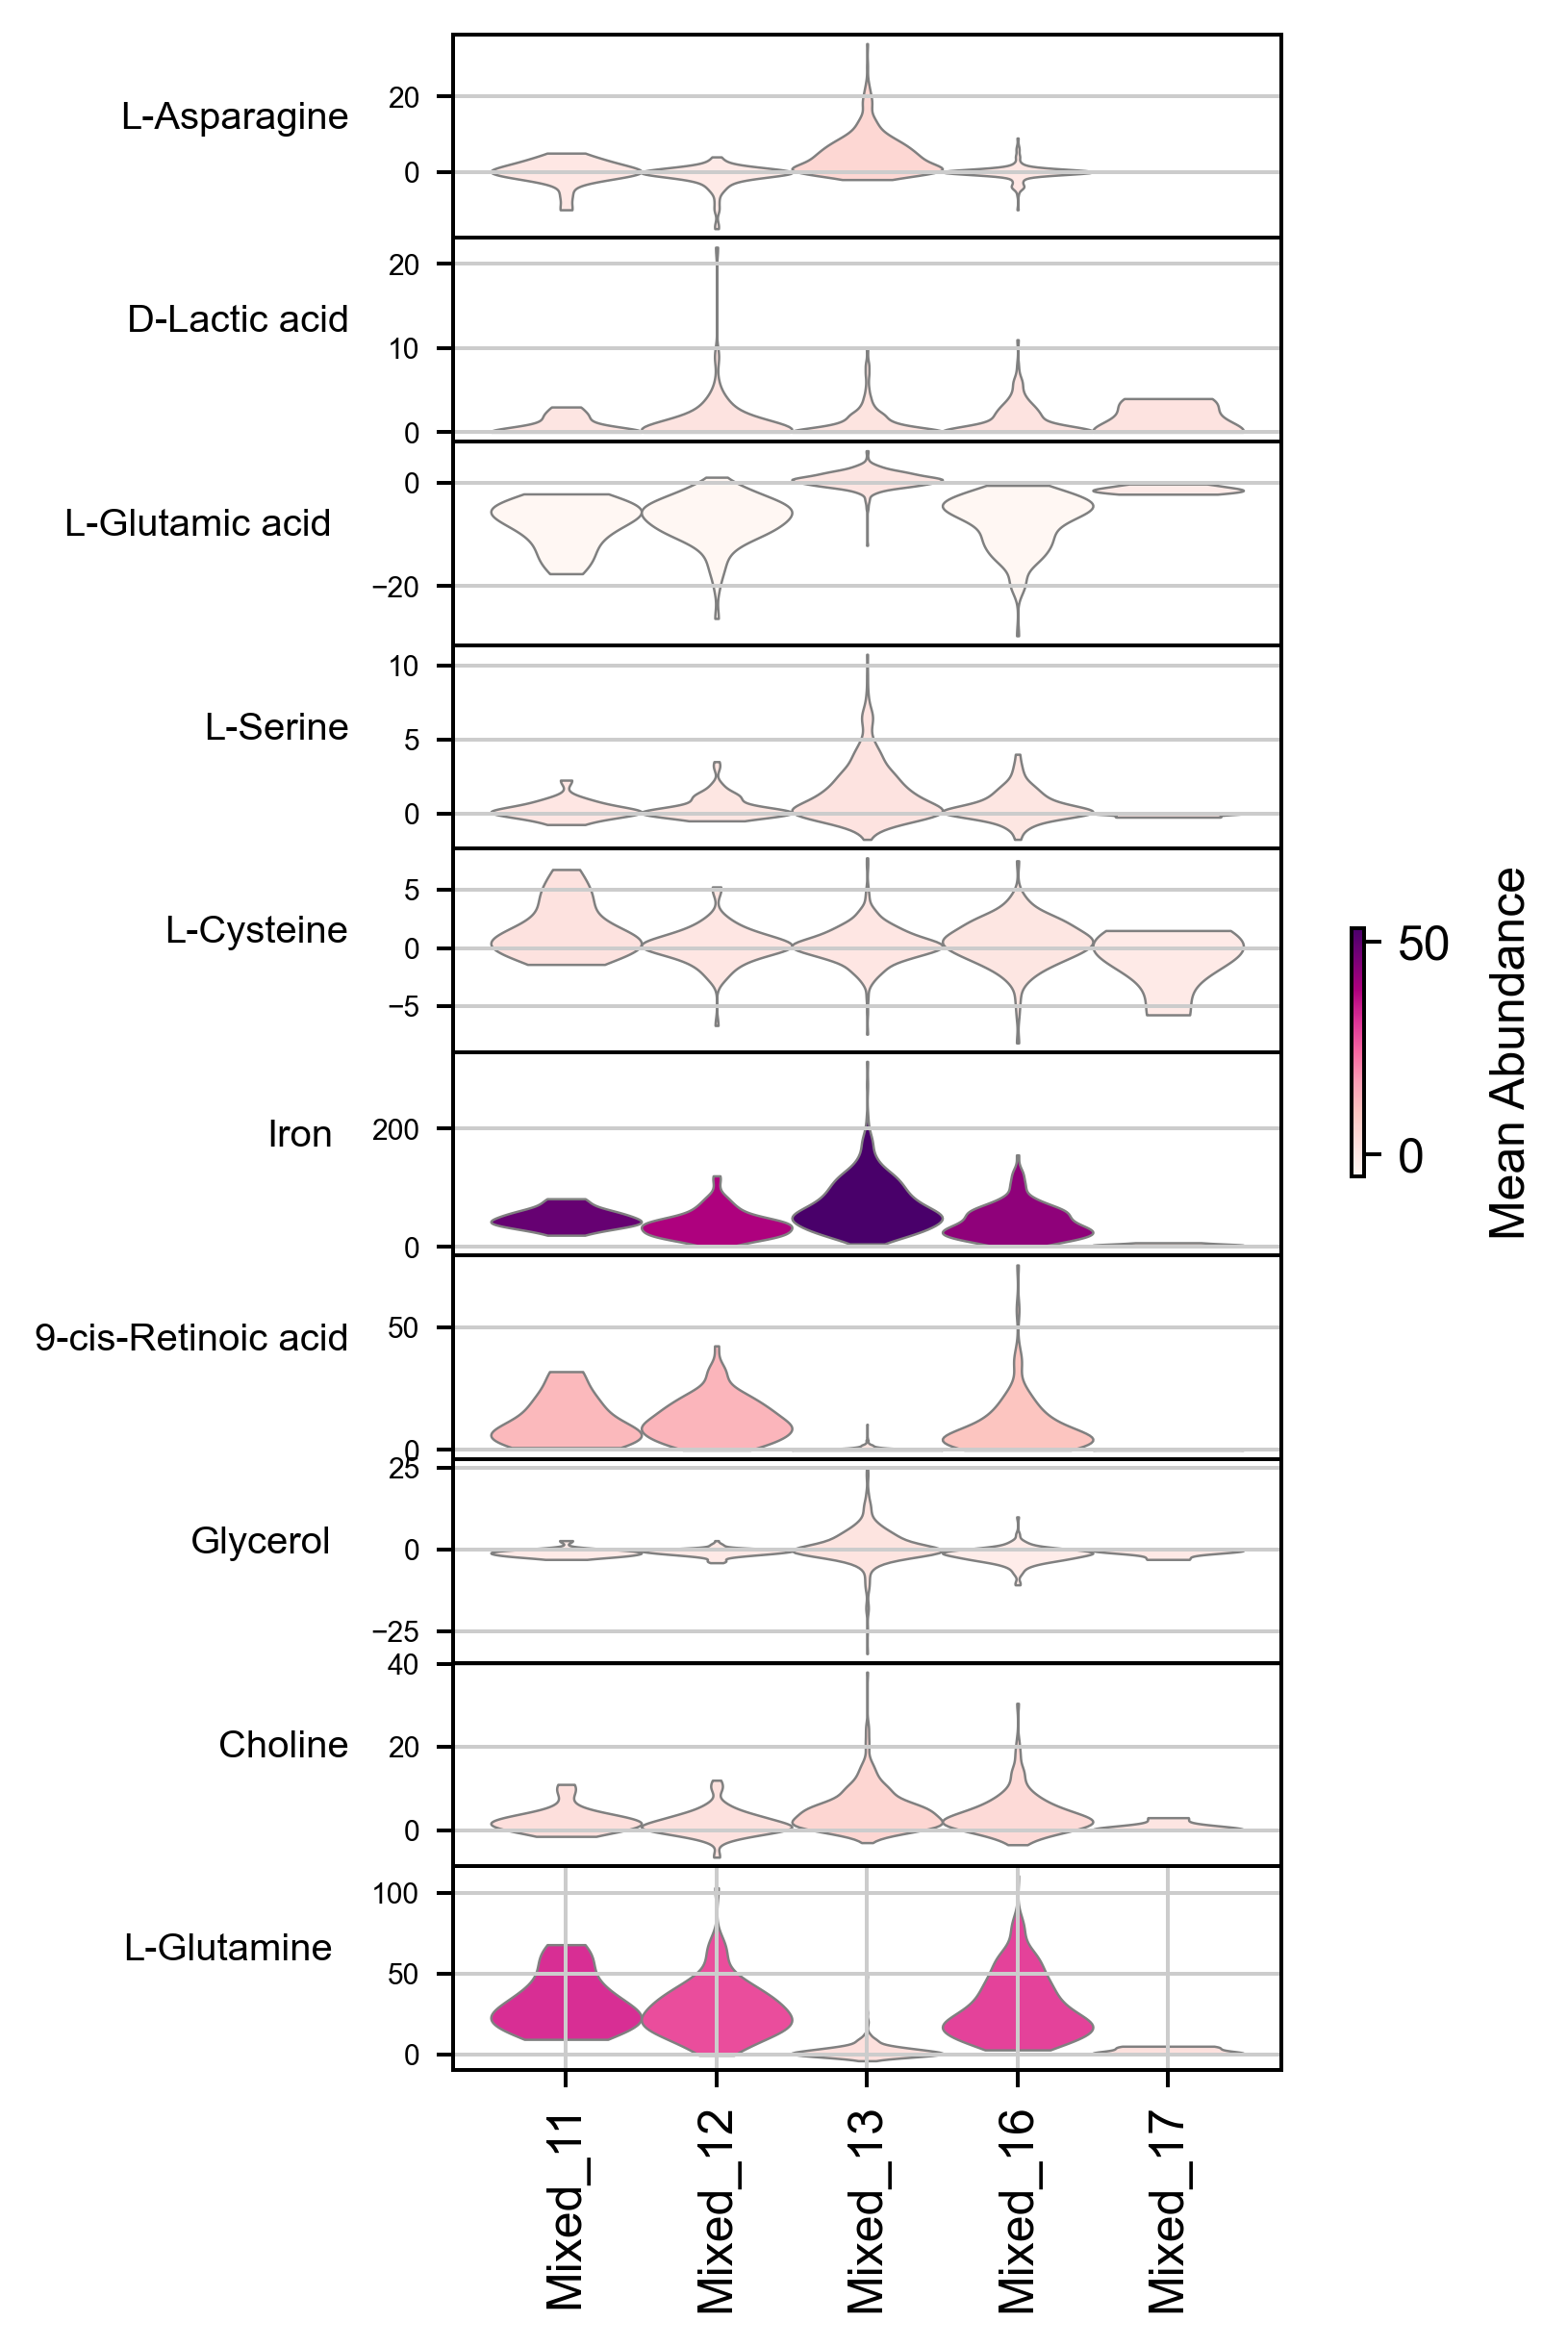

In [20]:
commu_df = mebo_obj.commu_res.copy()
good_met = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Metabolite_Name'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met = good_met[:10], ## only top 5 as example
                    cell_focus = [],
                    cmap = 'RdPu',
                    vmin = None,
                    vmax = None,
                    figsize = 'auto',
                    cbar_title = '',
                    save = None,
                    show_plot = True
                    )

[May 10, 2023 11:36:30]: Find genes Index(['AQP3', 'SLC11A2', 'SLC16A1', 'SLC1A4', 'SLC1A5', 'SLC38A1', 'SLC38A2',
       'SLC38A5', 'SLC38A7', 'SLC3A2'],
      dtype='object') to plot violin


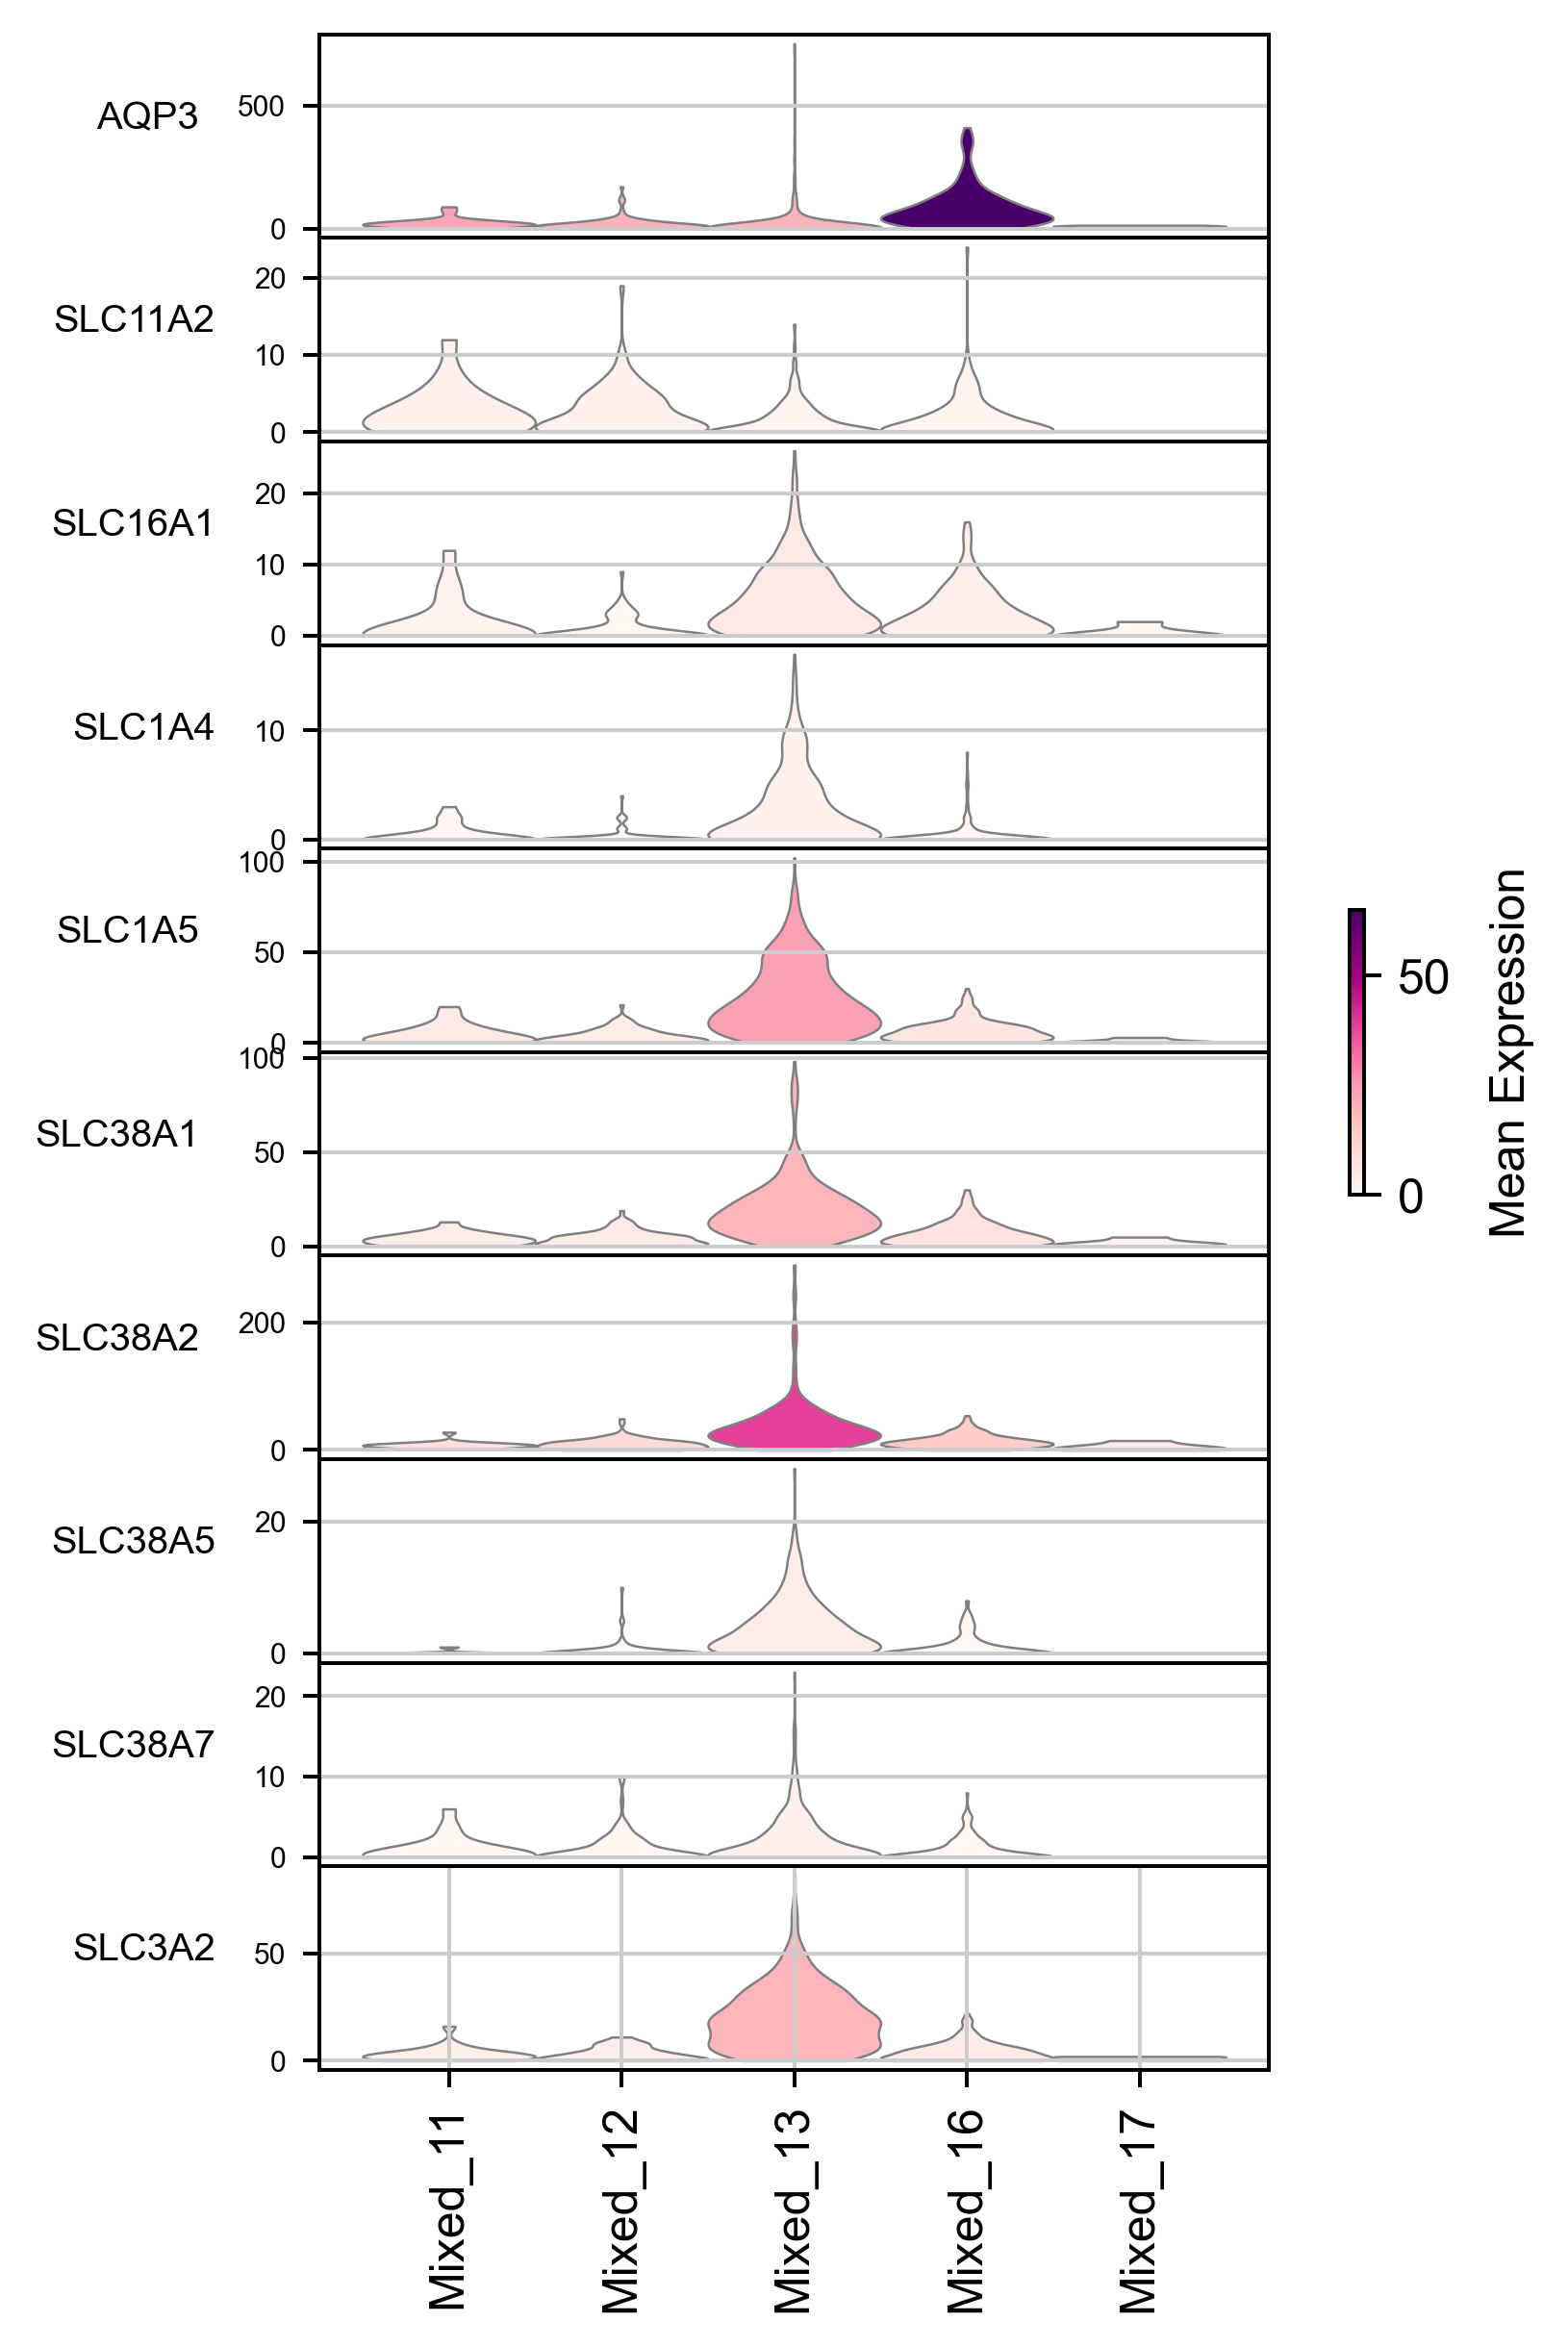

[May 10, 2023 11:36:31]: Warnings: no metabolites to plot


In [21]:
good_sensor = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Sensor'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met = good_sensor[:10],## only top 5 as example
                    cell_focus = [],
                    cmap = 'RdPu',
                    vmin = None,
                    vmax = None,
                    figsize = 'auto',
                    cbar_title = '',
                    save = None,
                    show_plot = True
                    )
